## Import required Librarys

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import tensorflow_hub as hub
import numpy as np
import cv2 

## Usefull functions

### function showing progres in learning of the model

In [13]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

### function to make preatty confusion_matrix

In [14]:

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 

  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

## Preparing data

In [15]:
train_path = './gesture/train'
test_path = './gesture/test'
valid_path = './gesture/validate'

In [16]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (64, 64)                              

#shuffle train dataset
train = tf.keras.preprocessing.image_dataset_from_directory(train_path,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=True)
                                                                
validate = tf.keras.preprocessing.image_dataset_from_directory(valid_path,
                                                                        label_mode="categorical",
                                                                        image_size=IMG_SIZE,
                                                                        shuffle=False)

test = tf.keras.preprocessing.image_dataset_from_directory(test_path,
                                                                        label_mode="categorical",
                                                                        image_size=IMG_SIZE,
                                                                        shuffle=False)


Found 14424 files belonging to 24 classes.
Found 1026 files belonging to 24 classes.
Found 989 files belonging to 24 classes.


## Create checkpoint_callback to be able to continue training model

In [17]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [18]:
# Setup checkpoint path
checkpoint_path = "./checkpoints/B0/checkpoint.ckpt" 

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=False, # set to True to save only the best model instead of a model every epoch 
                                                         save_freq="epoch")

## Create model using transfer learnining with EfficientNetB0

In [19]:
# Build data augmentation layer
data_augmentation = Sequential([
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomRotation(0.2),                
], name="data_augmentation")

# Setup the input shape to our model
input_shape = (64, 64, 3)

# Create a frozen base model
base_model = tf.keras.applications.EfficientNetB0(input_shape=(64, 64, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

# Create input and output layers
inputs = layers.Input(shape=input_shape, name="input_layer") # create input layer
x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model 
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(24, activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

## Train for 100 epocks

In [20]:
history_50_epocks = model.fit(train,
                                        
                                          epochs=50,
                                          validation_data=validate,
                                          validation_steps=len(validate),
                                          callbacks=[create_tensorboard_callback("transfer_learning", "ProjectEfficientNet"), 
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/ProjectEfficientNet/20230309-115323
Epoch 1/50
451/451 [==============================] - 33s 65ms/step - loss: 1.1569 - accuracy: 0.7060 - val_loss: 1.4668 - val_accuracy: 0.5497
Epoch 2/50
451/451 [==============================] - 29s 65ms/step - loss: 0.5252 - accuracy: 0.8683 - val_loss: 1.2952 - val_accuracy: 0.6111
Epoch 3/50
451/451 [==============================] - 29s 64ms/step - loss: 0.3923 - accuracy: 0.9023 - val_loss: 1.2445 - val_accuracy: 0.6530
Epoch 4/50
451/451 [==============================] - 29s 64ms/step - loss: 0.3288 - accuracy: 0.9155 - val_loss: 1.2590 - val_accuracy: 0.6296
Epoch 5/50
451/451 [==============================] - 29s 64ms/step - loss: 0.2804 - accuracy: 0.9287 - val_loss: 1.2854 - val_accuracy: 0.6462
Epoch 6/50
451/451 [==============================] - 31s 69ms/step - loss: 0.2518 - accuracy: 0.9362 - val_loss: 1.2600 - val_accuracy: 0.6442
Epoch 7/50
451/451 [=============================

### Show the performance of the model

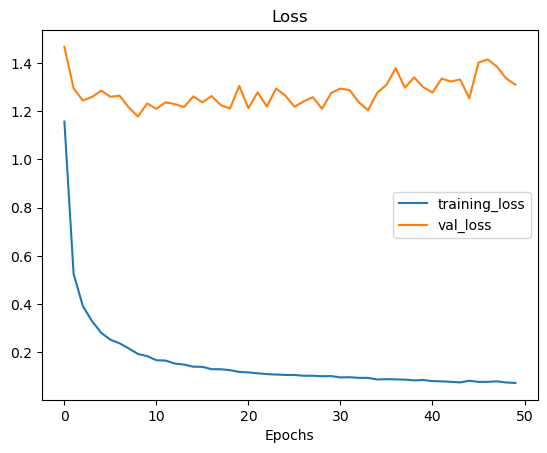

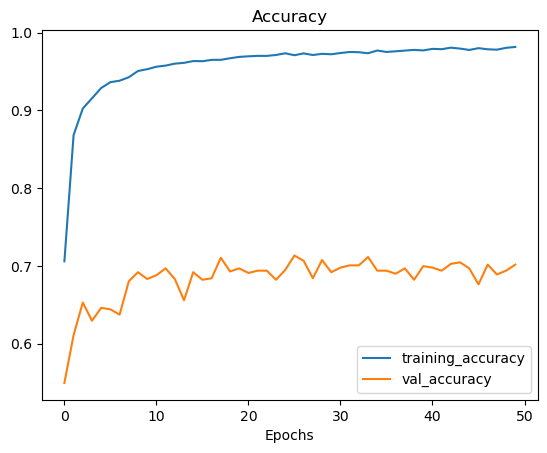

In [21]:
plot_loss_curves(history_50_epocks)

## Load best epock

In [22]:
model.save('model_EfficientNetB0.h5')

In [23]:

# Load in saved model weights and evaluate model
model.load_weights(checkpoint_path)
loaded_weights_model_results = model.evaluate(test)

31/31 [==============================] - 2s 64ms/step - loss: 0.8659 - accuracy: 0.7108


## Evaluate it on test dataset

In [24]:
# Make predictions with model
pred_probs = model.predict(test)

31/31 [==============================] - 3s 64ms/step


In [25]:
# Get the class names
class_names = validate.class_names
class_names

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y']

In [26]:
# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

In [27]:

y_labels = []
for images, labels in test.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)

In [28]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.7108190091001011

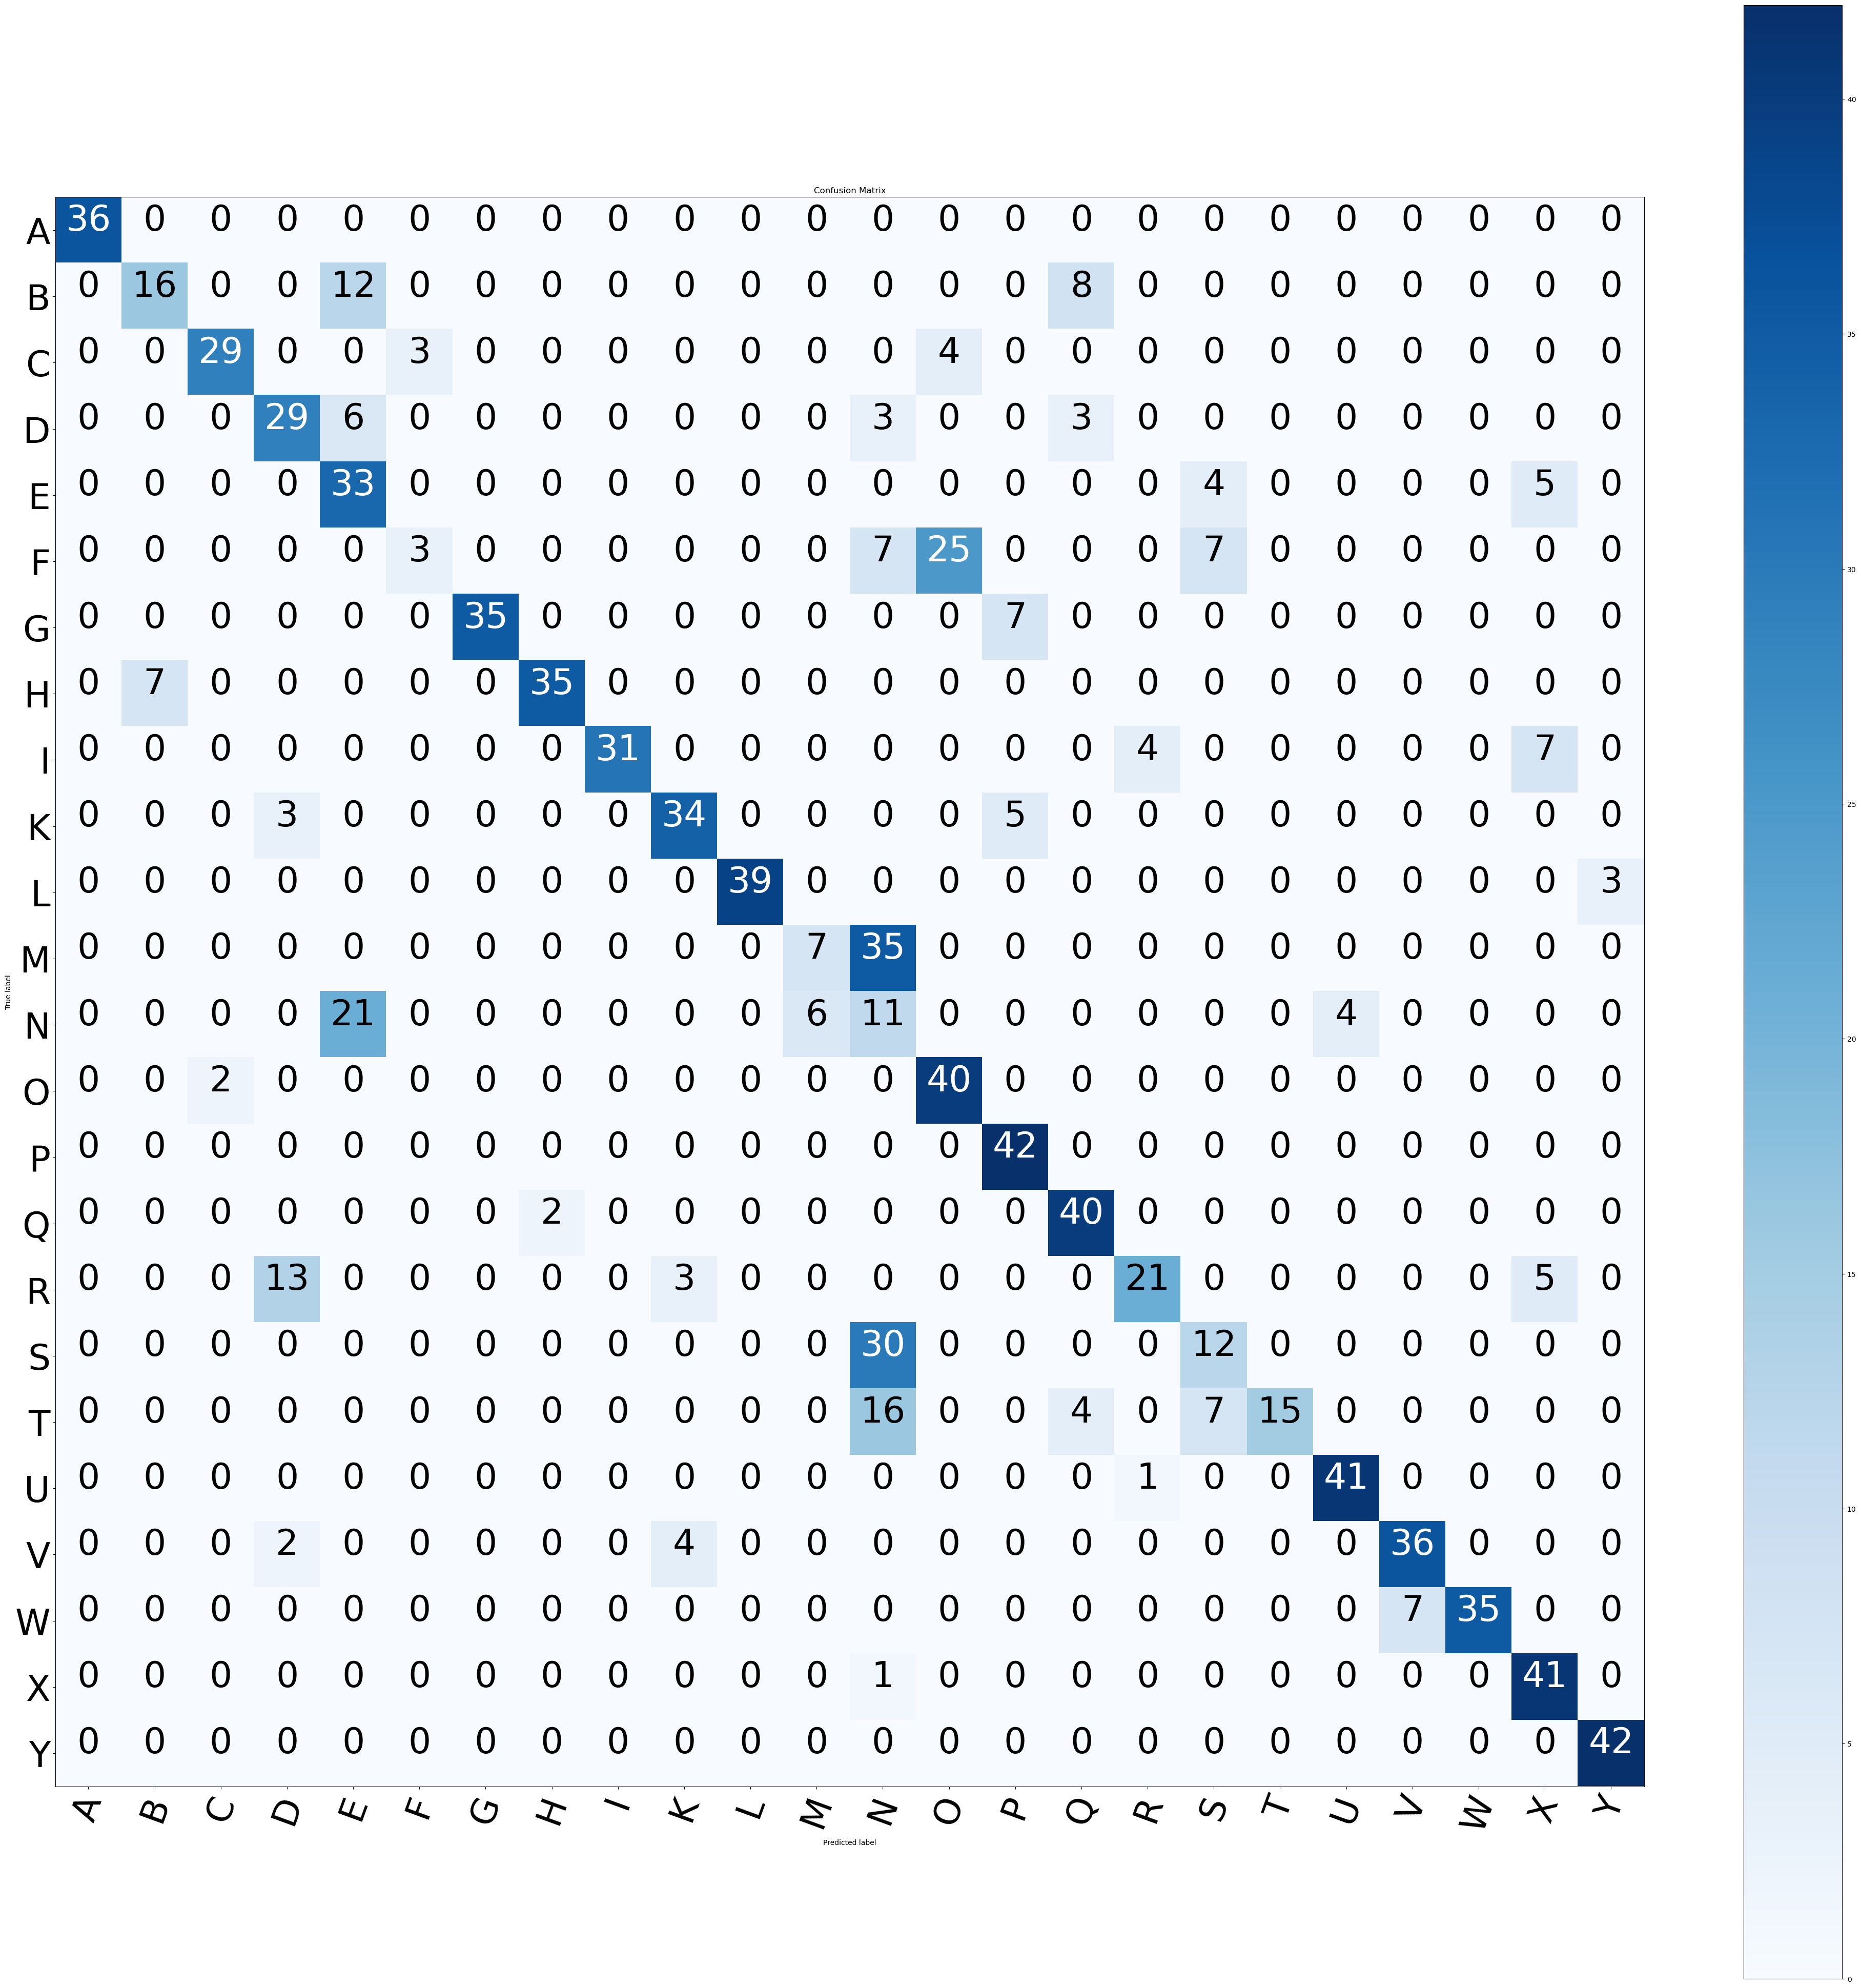

In [29]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(50, 50),
                      text_size=50,
                      norm=False,
                      savefig=True)

In [30]:

from sklearn.metrics import classification_report
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)

In [31]:

# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'A': 1.0,
 'B': 0.5423728813559322,
 'C': 0.8656716417910448,
 'D': 0.6590909090909092,
 'E': 0.5789473684210527,
 'F': 0.125,
 'G': 0.9090909090909091,
 'H': 0.8860759493670887,
 'I': 0.8493150684931507,
 'K': 0.8192771084337348,
 'L': 0.962962962962963,
 'M': 0.2545454545454545,
 'N': 0.15172413793103448,
 'O': 0.7207207207207207,
 'P': 0.8750000000000001,
 'Q': 0.8247422680412371,
 'R': 0.6176470588235294,
 'S': 0.3333333333333333,
 'T': 0.5263157894736842,
 'U': 0.9425287356321839,
 'V': 0.8470588235294119,
 'W': 0.9090909090909091,
 'X': 0.8199999999999998,
 'Y': 0.9655172413793104}

In [32]:

# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores

,class_name,f1-score
0,A,1.000000
23,Y,0.965517
10,L,0.962963
19,U,0.942529
21,W,0.909091
6,G,0.909091
7,H,0.886076
14,P,0.875000
2,C,0.865672
8,I,0.849315


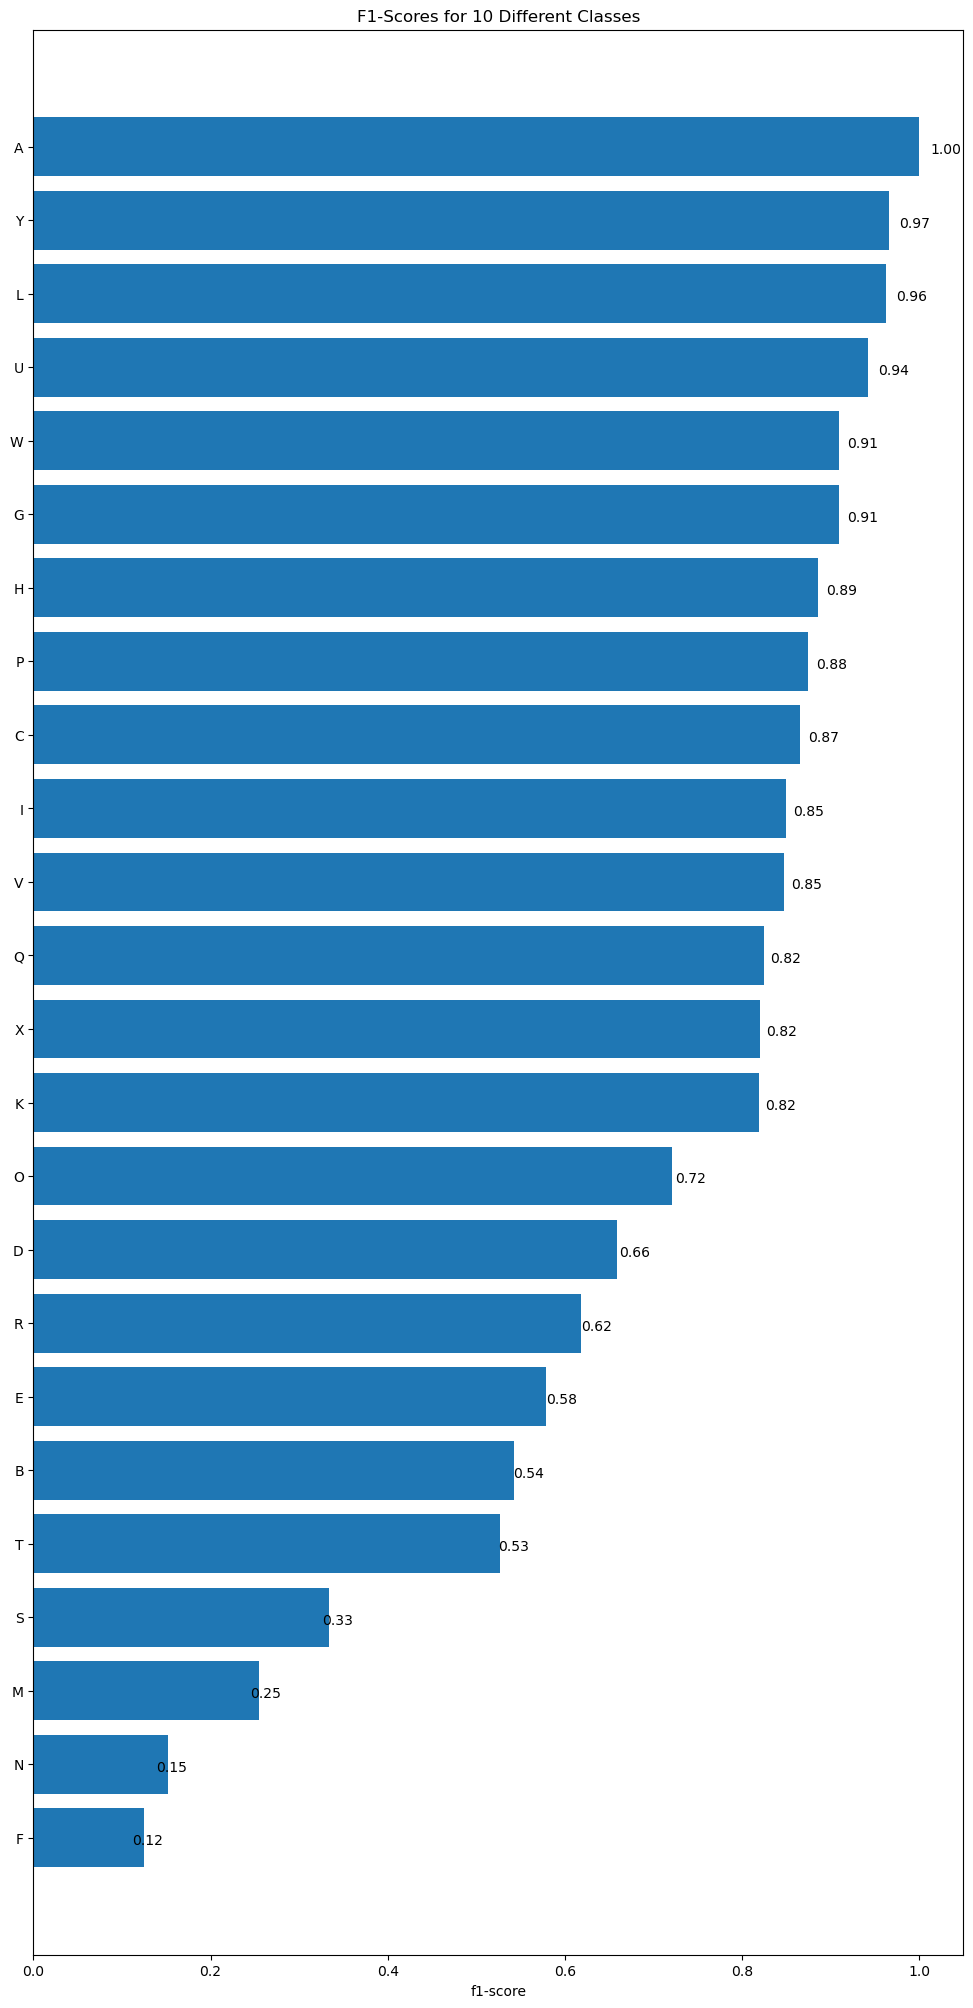

In [33]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): 
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

## Resnet

In [38]:
# Build data augmentation layer
data_augmentation = Sequential([
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomRotation(0.2),
  preprocessing.Rescaling(1./255)
], name="data_augmentation")


# Setup the input shape to our model
input_shape = (64, 64, 3)

# Create a frozen base model
base_model = tf.keras.applications.resnet50.ResNet50(input_shape=(64,64,3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

# Create input and output layers
inputs = layers.Input(shape=input_shape, name="input_layer") # create input layer
x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model 
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(24, activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [39]:
history_resnet = model.fit(train,
                                        
                                          epochs=50,
                                          validation_data=validate,
                                          validation_steps=len(validate), 
                                          callbacks=[create_tensorboard_callback("transfer_learning", "ProjecResNet"), 
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/ProjecResNet/20230309-160735
Epoch 1/50
451/451 [==============================] - 71s 152ms/step - loss: 2.6088 - accuracy: 0.2922 - val_loss: 2.4435 - val_accuracy: 0.2417
Epoch 2/50
451/451 [==============================] - 66s 147ms/step - loss: 2.0557 - accuracy: 0.4587 - val_loss: 2.1989 - val_accuracy: 0.3324
Epoch 3/50
451/451 [==============================] - 66s 146ms/step - loss: 1.7836 - accuracy: 0.5352 - val_loss: 2.0639 - val_accuracy: 0.3431
Epoch 4/50
451/451 [==============================] - 66s 146ms/step - loss: 1.6124 - accuracy: 0.5830 - val_loss: 1.9573 - val_accuracy: 0.3587
Epoch 5/50
451/451 [==============================] - 65s 144ms/step - loss: 1.5044 - accuracy: 0.6074 - val_loss: 1.9089 - val_accuracy: 0.3713
Epoch 6/50
451/451 [==============================] - 66s 147ms/step - loss: 1.3962 - accuracy: 0.6402 - val_loss: 1.8580 - val_accuracy: 0.3460
Epoch 7/50
451/451 [==============================

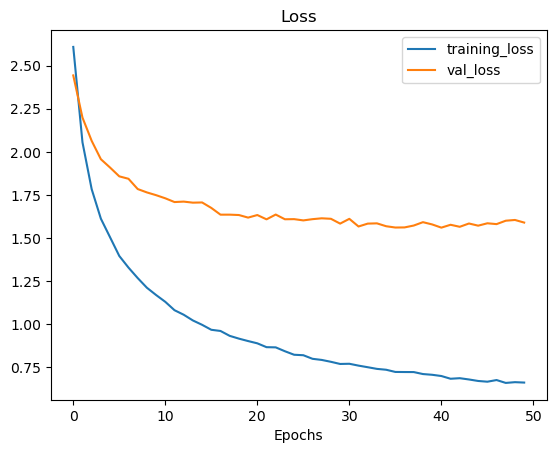

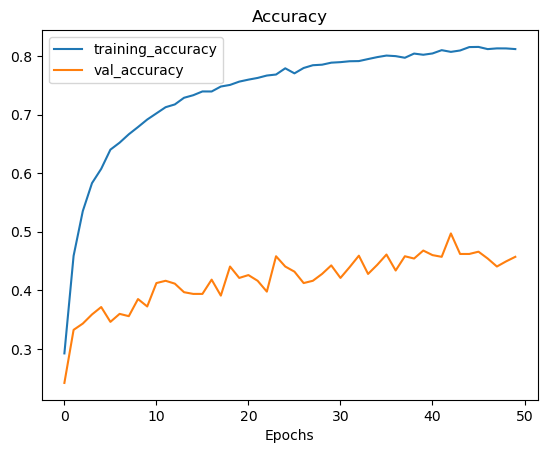

In [40]:
plot_loss_curves(history_resnet)

In [41]:
# Make predictions with model
pred_probs = model.predict(test)

31/31 [==============================] - 5s 129ms/step


In [42]:
# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

In [43]:

y_labels = []
for images, labels in test.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)

In [44]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.5338725985844287

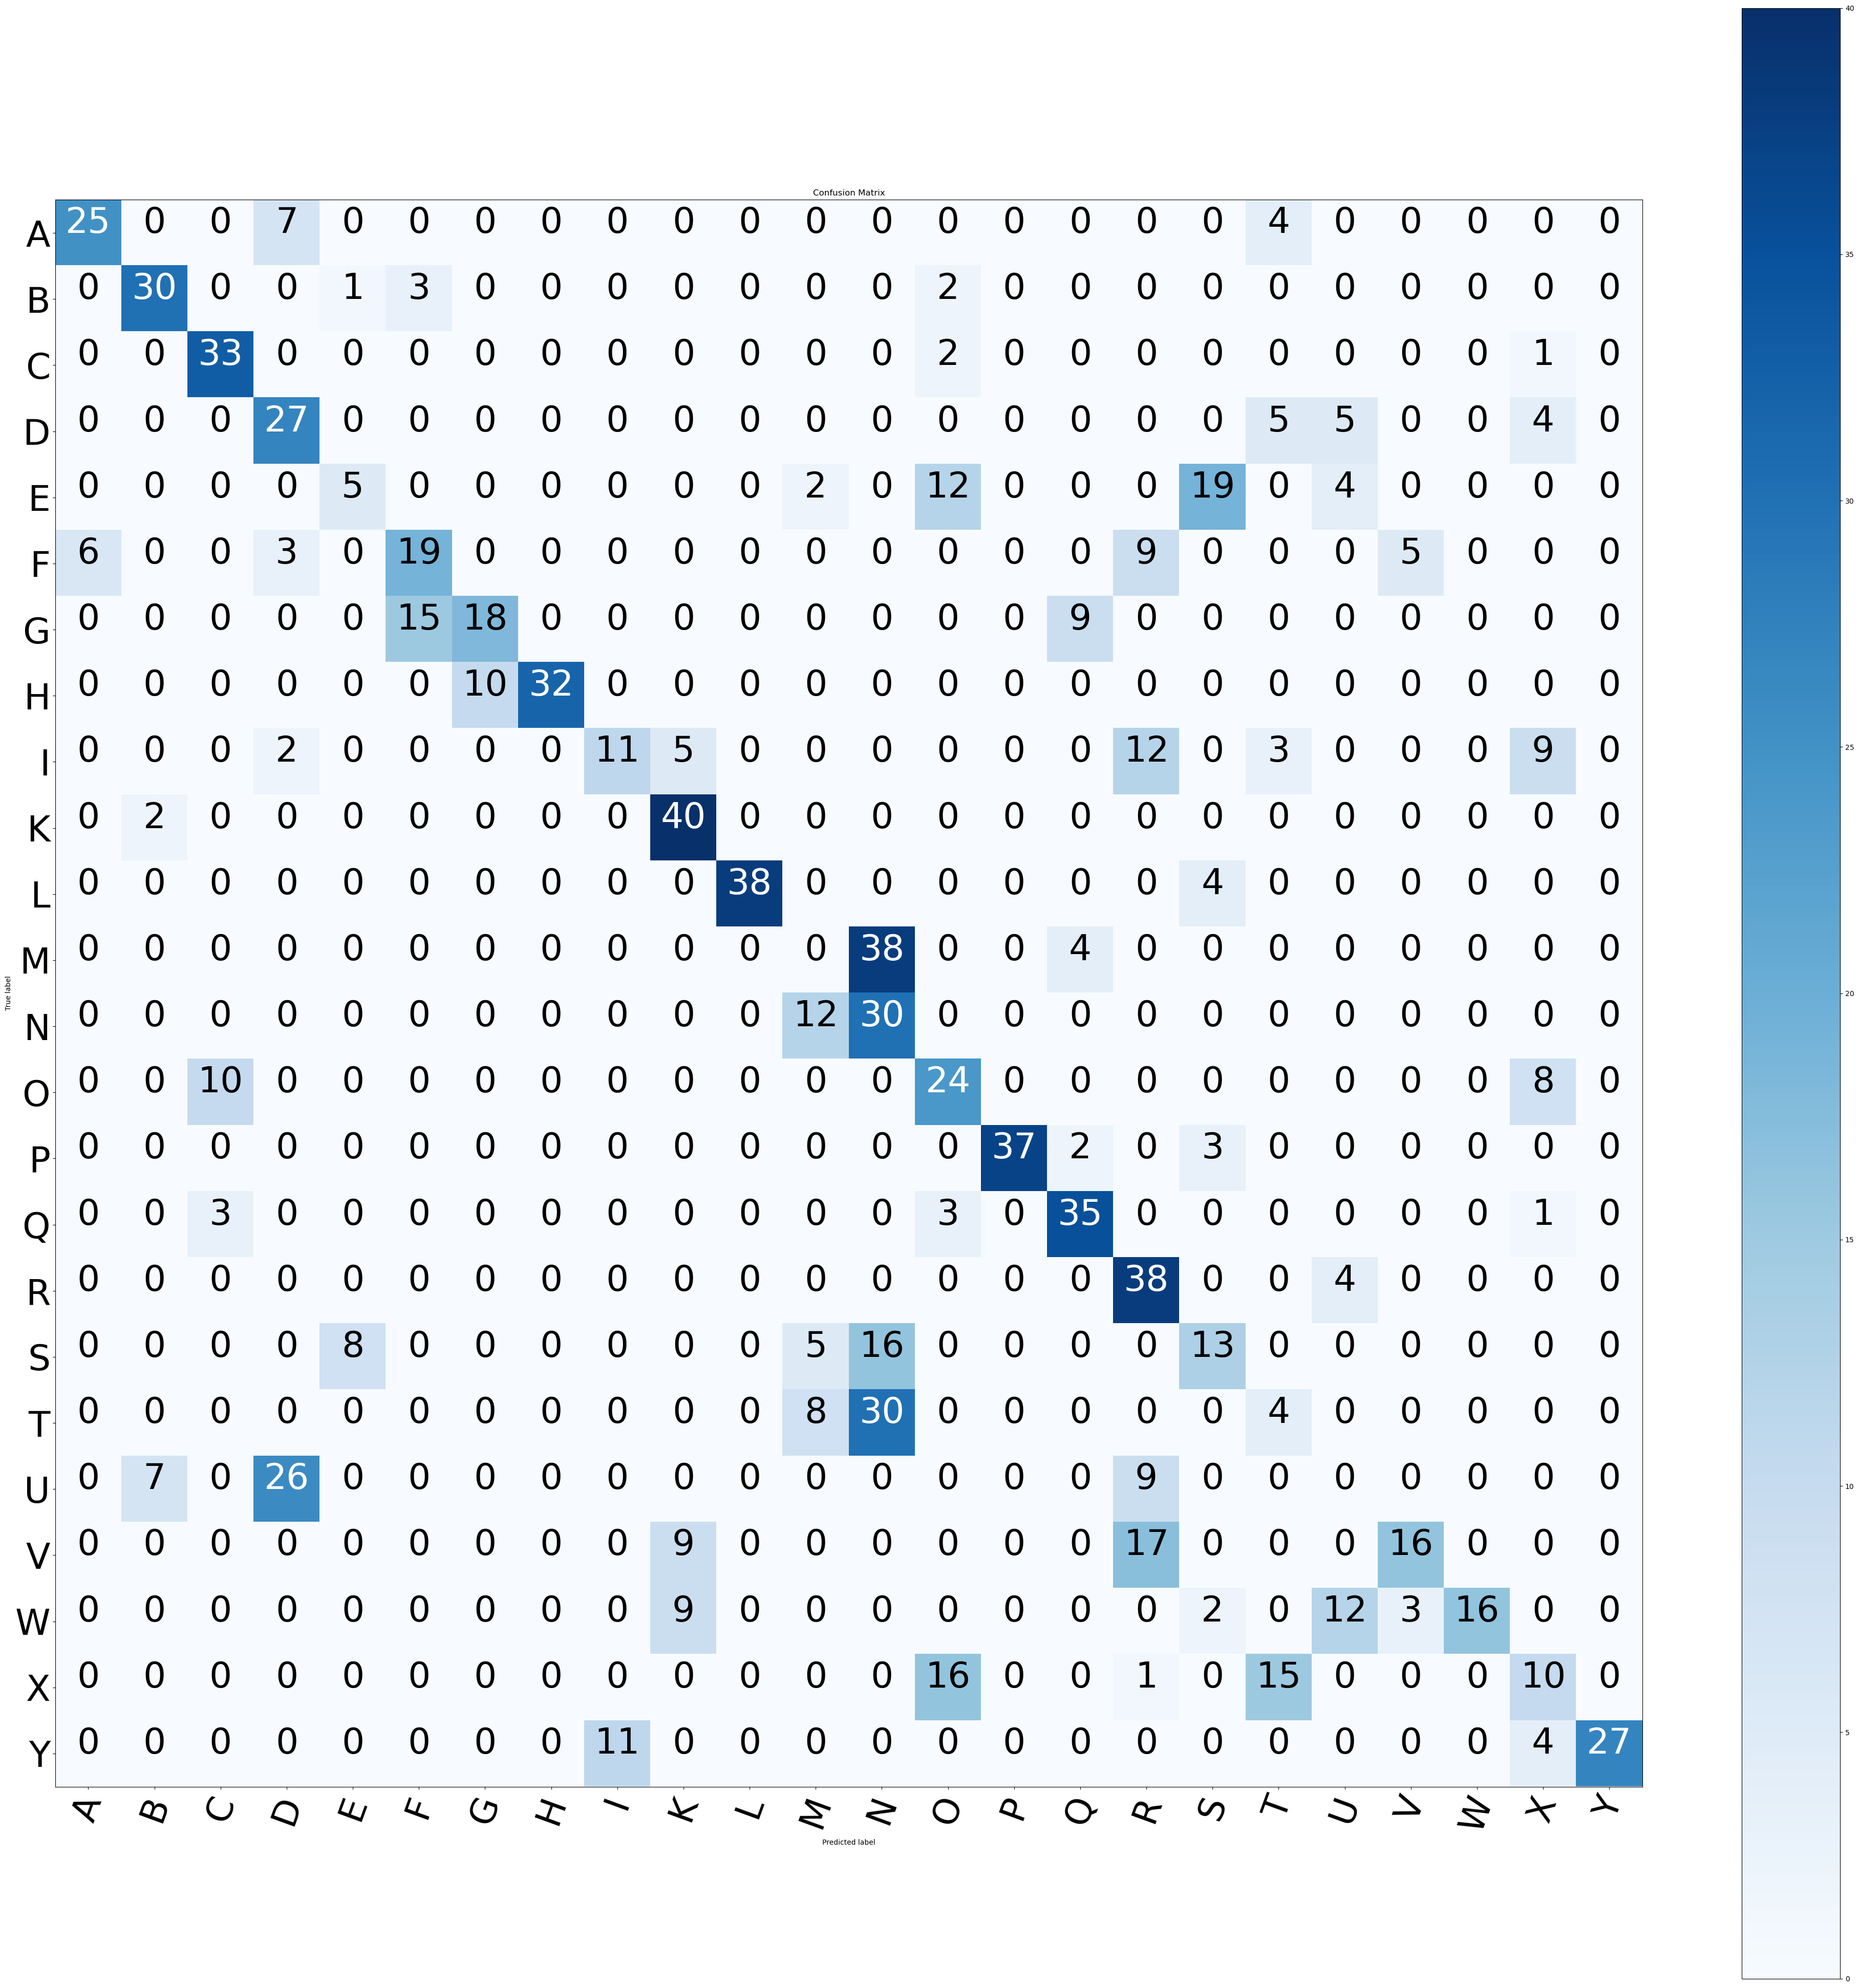

In [45]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(50, 50),
                      text_size=50,
                      norm=False,
                      savefig=False)

## MobileNetV2

In [46]:
# Build data augmentation layer
data_augmentation = Sequential([
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomRotation(0.2), 
  preprocessing.Rescaling(1./255) 
], name="data_augmentation")


# Setup the input shape to our model
input_shape = (64, 64, 3)

# Create a frozen base model
base_model = tf.keras.applications.MobileNetV2(input_shape=(64,64,3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

# Create input and output layers
inputs = layers.Input(shape=input_shape, name="input_layer") # create input layer
x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model 
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(24, activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [47]:
history_MobileNetV2 = model.fit(train,
                                        
                                          epochs=50,
                                          validation_data=validate,
                                          validation_steps=len(validate),
                                          callbacks=[create_tensorboard_callback("transfer_learning", "ProjecMobileNetV2t"), 
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/ProjecMobileNetV2t/20230309-170304
Epoch 1/50
451/451 [==============================] - 21s 42ms/step - loss: 1.3587 - accuracy: 0.6217 - val_loss: 1.7019 - val_accuracy: 0.4747
Epoch 2/50
451/451 [==============================] - 20s 44ms/step - loss: 0.7476 - accuracy: 0.7927 - val_loss: 1.5775 - val_accuracy: 0.5000
Epoch 3/50
451/451 [==============================] - 20s 44ms/step - loss: 0.5897 - accuracy: 0.8334 - val_loss: 1.5190 - val_accuracy: 0.5429
Epoch 4/50
451/451 [==============================] - 20s 44ms/step - loss: 0.5245 - accuracy: 0.8509 - val_loss: 1.4765 - val_accuracy: 0.5439
Epoch 5/50
451/451 [==============================] - 20s 44ms/step - loss: 0.4716 - accuracy: 0.8631 - val_loss: 1.5167 - val_accuracy: 0.5663
Epoch 6/50
451/451 [==============================] - 20s 44ms/step - loss: 0.4515 - accuracy: 0.8709 - val_loss: 1.5406 - val_accuracy: 0.5341
Epoch 7/50
451/451 [==============================

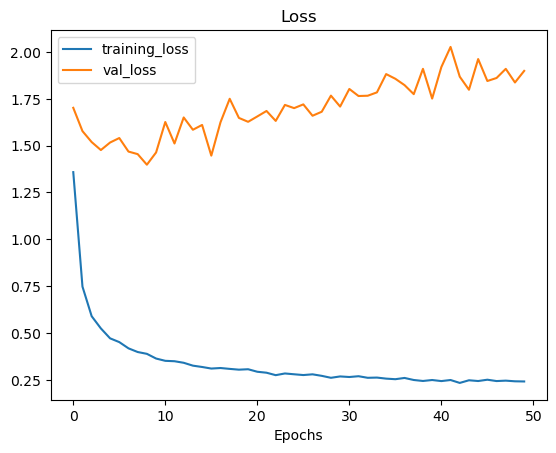

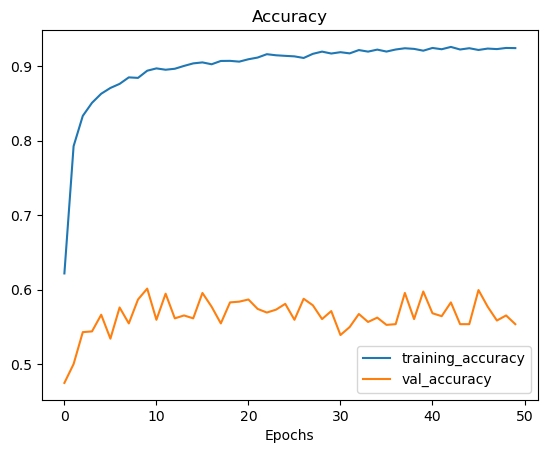

In [48]:
plot_loss_curves(history_MobileNetV2)

In [49]:
# Make predictions with model
pred_probs = model.predict(test)

31/31 [==============================] - 2s 37ms/step


In [50]:
# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

In [51]:

y_labels = []
for images, labels in test.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)

In [52]:
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.537917087967644

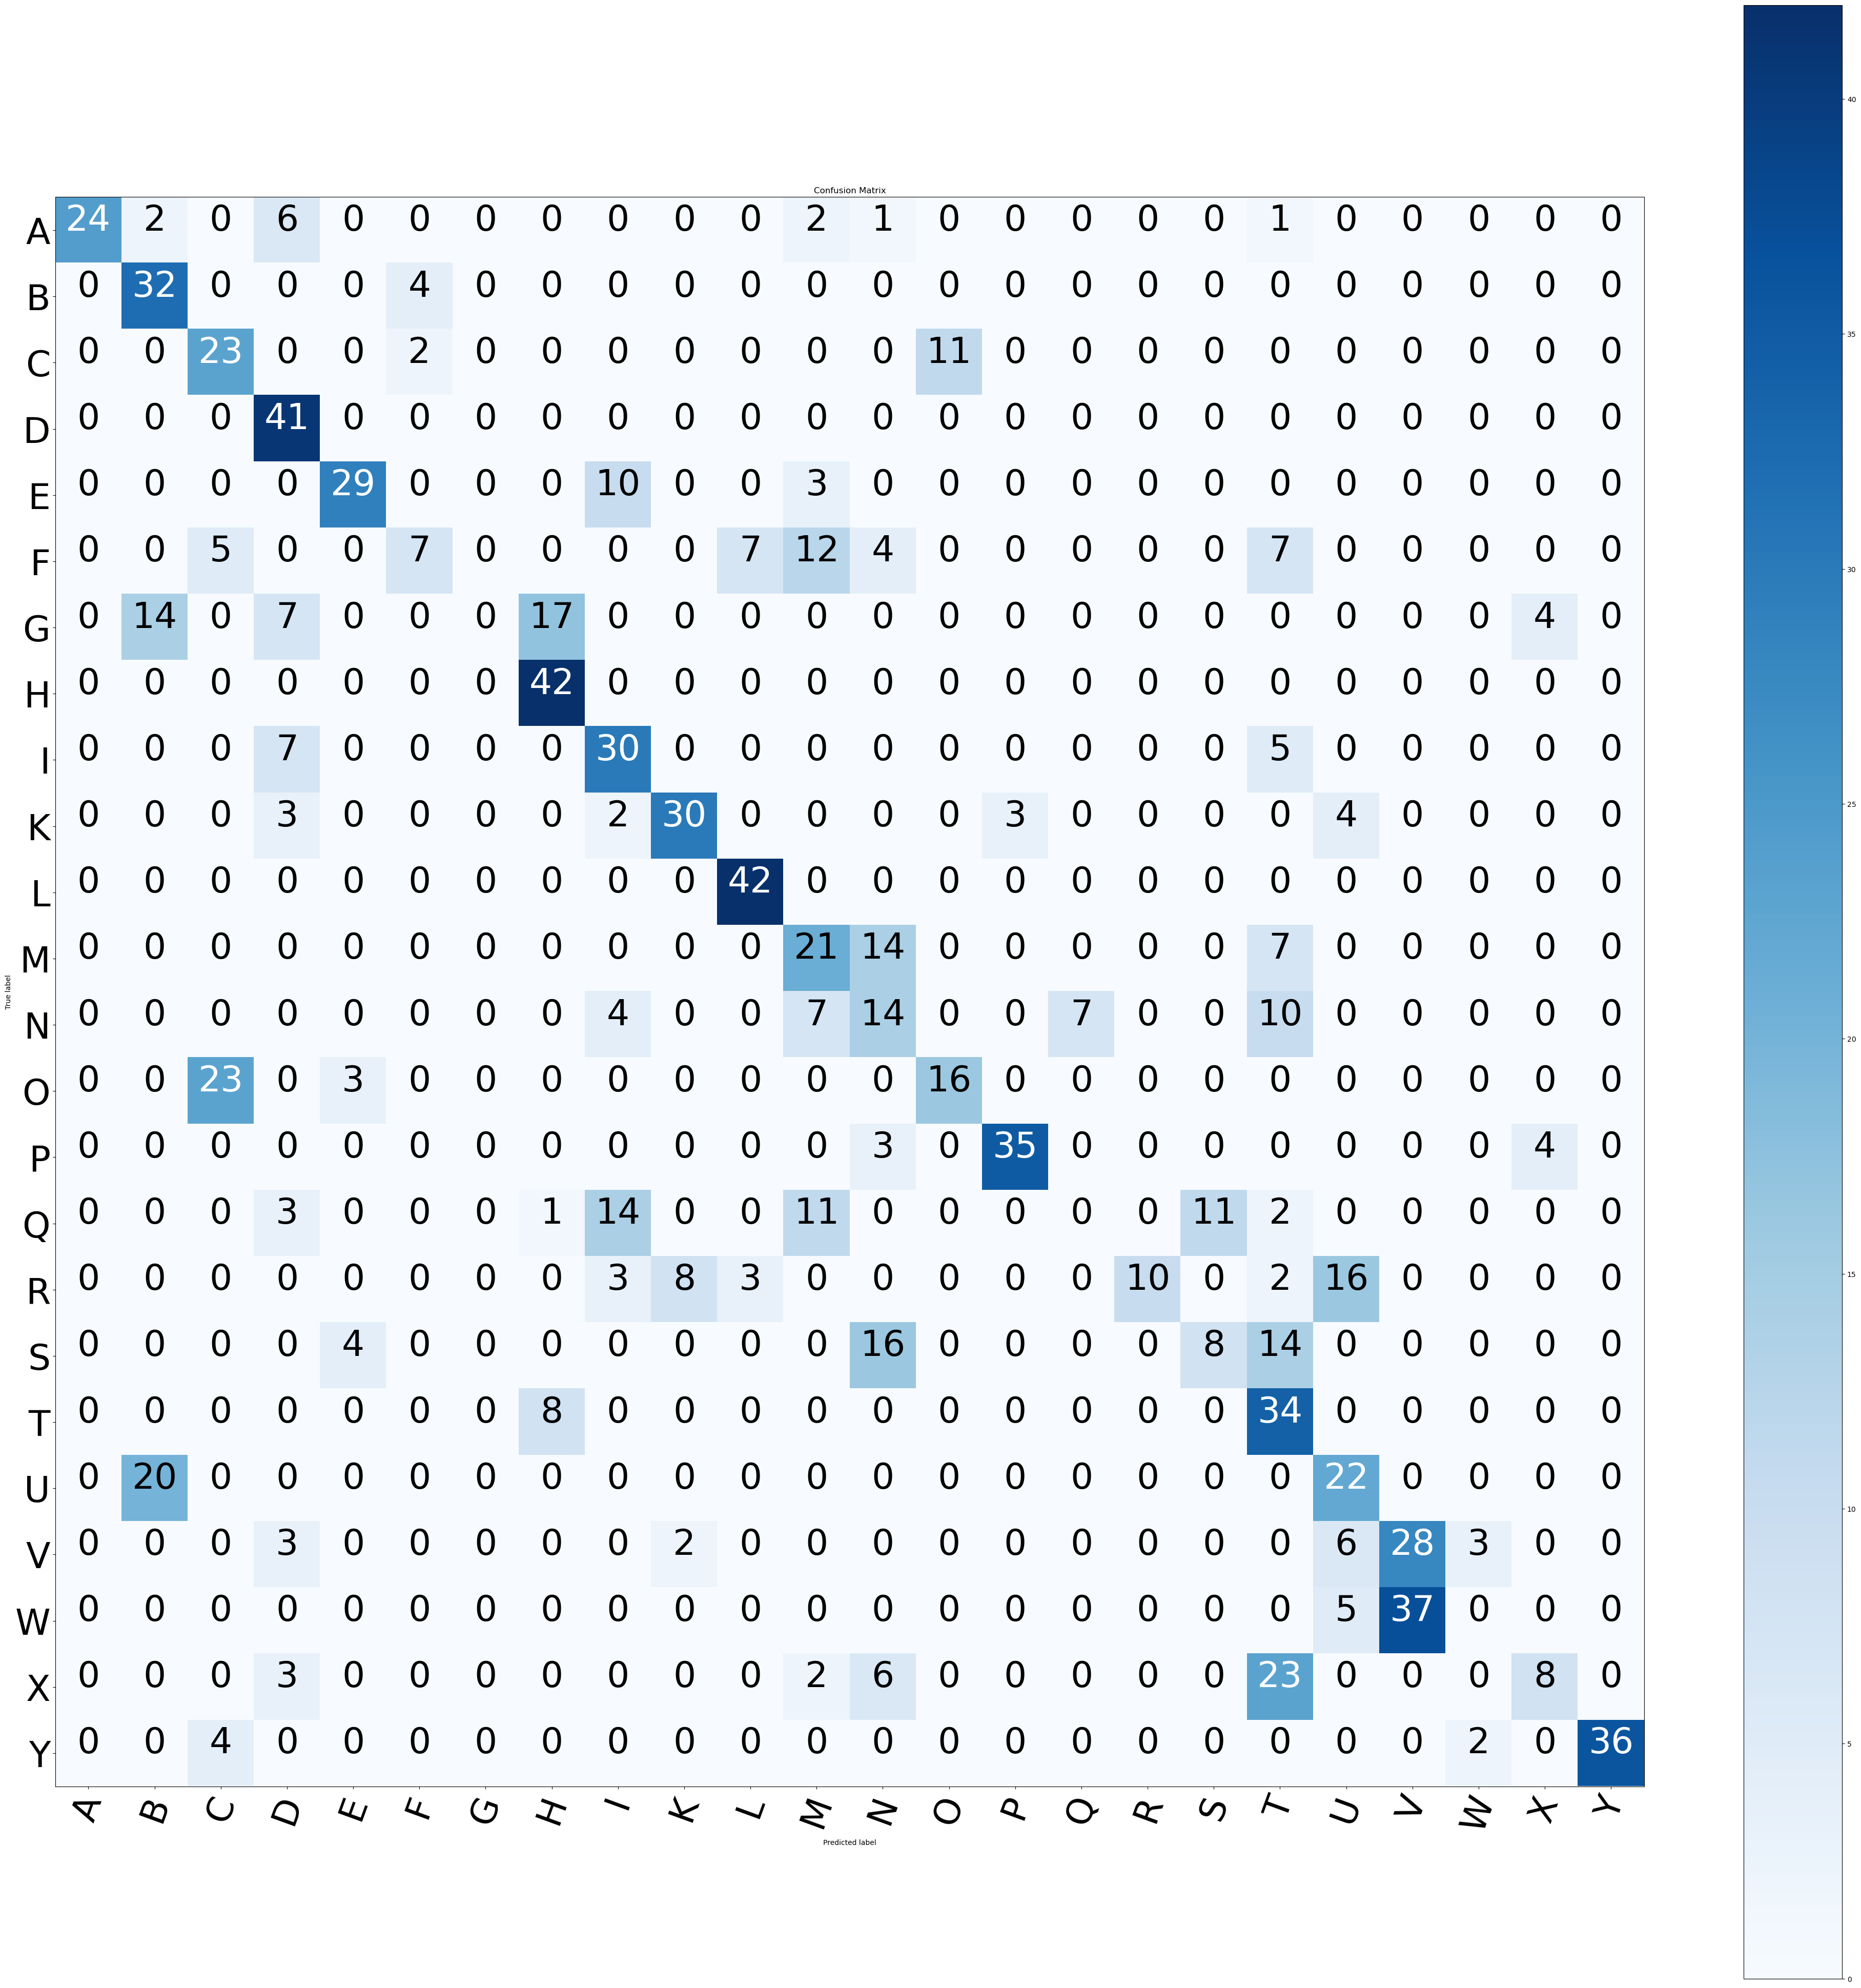

In [53]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(50, 50),
                      text_size=50,
                      norm=False,
                      savefig=False)